In [1]:
import datetime

import numpy as np
import numpy.random as rndm
import matplotlib.pyplot as plt
rng = rndm.default_rng()

In [2]:
NUM_CASTLES = 13
NUM_SOLDIERS = 100
CASTLE_POINTS = np.arange(1, NUM_CASTLES+1, dtype=np.int8)
CASTLE_SUM = CASTLE_POINTS.sum()

def random_dist():
    output = np.zeros((NUM_CASTLES,), dtype=np.int8)
    castles = rng.integers(0, NUM_CASTLES, NUM_SOLDIERS)
    for i in range(NUM_SOLDIERS):
        output[castles[i]] += 1
    return output

def battle_points(x, y):
    wins = np.zeros((NUM_CASTLES,), dtype=np.int8)
    for i in range(NUM_CASTLES):
        if x[i] < y[i]:
            wins[i] = -1
        elif x[i] > y[i]:
            wins[i] = 1
    return CASTLE_SUM + wins.dot(CASTLE_POINTS)

def battle_cmp(x, y):
    x_points = battle_points(x, y)
    if x_points > CASTLE_SUM:
        return 1
    elif x_points < CASTLE_SUM:
        return -1
    return 0

In [3]:
NUM_CONTENDERS = 3000

def battle_royale(contenders):
    wins = np.zeros((NUM_CONTENDERS,), dtype=np.int32)
    for i in range(NUM_CONTENDERS):
        for j in range(i+1, NUM_CONTENDERS):
            outcome = battle_cmp(contenders[i], contenders[j])
            # This is a bug: I should have use 0 instead of 1, so ties are not counted correctly.
            if outcome > 1:
                wins[i] += 1
            elif outcome < 1:
                wins[j] += 1
    return wins

In [4]:
def snp_mutate_contender(contender):
    change_soldiers = rng.integers(0, NUM_CASTLES, 2)
    if contender[change_soldiers[0]] > 0:
        contender[change_soldiers[0]] -= 1
        contender[change_soldiers[1]] += 1

def mutate_contender(contender):
    new_contender = contender.copy()
    coin = rng.integers(0, 2)
    while coin > 0:
        snp_mutate_contender(new_contender)
        coin = rng.integers(0, 2)
    return new_contender

def evolve_contenders(contenders, wins):
    survival_threshold = np.quantile(wins, 0.5)
    triple_reproduction_threshold = np.quantile(wins, 0.95)
    reproduction_threshold = np.quantile(wins, 0.7)
    baby_contenders = []
    for i in range(NUM_CONTENDERS):
        if wins[i] >= reproduction_threshold:
            baby_contenders.append(mutate_contender(contenders[i]))
    for i in range(NUM_CONTENDERS):
        if wins[i] >= triple_reproduction_threshold:
            baby_contenders.append(contenders[i])
            baby_contenders.append(mutate_contender(contenders[i]))
    for i in range(NUM_CONTENDERS):
        if wins[i] < survival_threshold:
            if baby_contenders:
                contenders[i] = baby_contenders.pop()
            else:
                contenders[i] = random_dist()

In [5]:
contenders = np.zeros((NUM_CONTENDERS, NUM_CASTLES), dtype=np.int8)
for i in range(NUM_CONTENDERS):
    contenders[i][:] = random_dist()

In [6]:
NUM_ROUNDS = 1000
winners_circle = np.zeros((NUM_ROUNDS, NUM_CASTLES), dtype=np.int8)
dist = np.zeros((NUM_ROUNDS, NUM_CASTLES, NUM_SOLDIERS+1), dtype=np.int32)
for i in range(NUM_ROUNDS):
    for j in range(NUM_CONTENDERS):
        for k in range(NUM_CASTLES):
            dist[i,k,contenders[j,k]] += 1
    wins = battle_royale(contenders)
    win_index = wins.argmax()
    winner = contenders[win_index]
    if (i+1) % 1 == 0:
        print(datetime.datetime.now(), winner, wins[win_index])
    winners_circle[i] = winner
    evolve_contenders(contenders, wins)

2020-09-04 14:22:04.011137 [ 4  3  6 12  5  7  9  4 10  9 11 11  9] 2582
2020-09-04 14:22:43.704335 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2532
2020-09-04 14:23:23.359975 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2465
2020-09-04 14:24:03.417012 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2372
2020-09-04 14:24:43.598217 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2307
2020-09-04 14:25:23.682476 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2225
2020-09-04 14:26:04.219808 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2120
2020-09-04 14:26:43.579466 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2002
2020-09-04 14:27:22.508523 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 2152
2020-09-04 14:28:01.507787 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 2120
2020-09-04 14:28:41.362314 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 2108
2020-09-04 14:29:20.343102 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 2146
2020-09-04 14:29:59.809964 [ 3  7  5  5  6  7  3 11  6  9  8 14 16] 2267
2020-09-04 14:30:38.661378 [ 3  7  5  5  6  7  3 11

2020-09-04 15:36:25.286560 [ 0  0  7  6  0  2  3  9 18 10 18  6 21] 1885
2020-09-04 15:37:05.981914 [ 0  0  7  6  0  2  3  9 18 10 18  6 21] 1870
2020-09-04 15:37:45.597641 [ 0  0  7  6  0  2  3  9 18 10 18  6 21] 1796
2020-09-04 15:38:25.725530 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1789
2020-09-04 15:39:06.040831 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1908
2020-09-04 15:39:46.117933 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1936
2020-09-04 15:40:25.760614 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1836
2020-09-04 15:41:05.508191 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1718
2020-09-04 15:41:45.431755 [ 5  4  7  7  9  7  9  7  9 11  7 17  1] 1861
2020-09-04 15:42:25.644397 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1984
2020-09-04 15:43:05.518876 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1936
2020-09-04 15:43:44.475828 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1807
2020-09-04 15:44:23.682057 [ 3  1  8  4  5  3  4 13  1  5 11 20 22] 1734
2020-09-04 15:45:02.663094 [ 3  1  8  4  5  3  4 13

2020-09-04 16:51:32.108926 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1701
2020-09-04 16:52:12.349068 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1700
2020-09-04 16:52:52.381105 [ 3  7  8  2  6  8  7 13  6  7 10 13 10] 1586
2020-09-04 16:53:32.520788 [ 1  0  0  2  1  0 12  3 11  4 19 23 24] 1610
2020-09-04 16:54:12.322847 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1677
2020-09-04 16:54:52.040635 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1738
2020-09-04 16:55:32.774072 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1609
2020-09-04 16:56:13.241006 [ 3  7  8  2  6  8  7 13  6  7 10 13 10] 1762
2020-09-04 16:56:54.194336 [ 0  1  0  0  1  3  7  1  5 16 27 24 15] 1595
2020-09-04 16:57:34.097719 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1828
2020-09-04 16:58:13.857776 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1724
2020-09-04 16:58:53.689646 [ 0  0  8  1  5  5  0 11  2  0 18 23 27] 1592
2020-09-04 16:59:33.724005 [ 3  7  8  2  6  8  7 13  6  7 10 13 10] 1855
2020-09-04 17:00:14.200489 [ 4  4  6  4  3  9 10  7

2020-09-04 18:05:49.048838 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1729
2020-09-04 18:06:28.911156 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1789
2020-09-04 18:07:08.154382 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1658
2020-09-04 18:07:47.938527 [ 5  1  6  4  6  5  4 13 10 10  9 14 13] 1621
2020-09-04 18:08:27.415834 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1665
2020-09-04 18:09:06.296191 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1708
2020-09-04 18:09:44.895979 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1737
2020-09-04 18:10:24.835397 [ 5  1  6  4  6  5  4 13 10 10  9 14 13] 1586
2020-09-04 18:11:04.498005 [ 0  2  6  2  0  0  3 15 12 18 16  9 17] 1646
2020-09-04 18:11:44.067027 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1746
2020-09-04 18:12:22.722461 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1807
2020-09-04 18:13:01.697023 [ 0  0  5  1  5  7  1  9  0  0 15 28 29] 1592
2020-09-04 18:13:41.476991 [ 5  1  6  4  6  5  4 13 10 10  9 14 13] 1652
2020-09-04 18:14:21.426503 [ 1  1  0  4  4  6 10  5

2020-09-04 19:20:07.241638 [ 5  4  7  7  9  7  9  7  9 11  7 17  1] 1430
2020-09-04 19:20:47.370582 [ 4  4  6  8  5  8  6 11 11 15  5  5 12] 1560
2020-09-04 19:21:27.833081 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1586
2020-09-04 19:22:07.388751 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1598
2020-09-04 19:22:46.667005 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1428
2020-09-04 19:23:25.662816 [ 4  4  6  8  5  8  6 11 11 15  5  5 12] 1519
2020-09-04 19:24:05.363148 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1534
2020-09-04 19:24:45.614775 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1593
2020-09-04 19:25:23.977159 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1442
2020-09-04 19:26:03.009989 [ 5  1  6  4  6  5  4 13 10 10  9 14 13] 1479
2020-09-04 19:26:42.142955 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1542
2020-09-04 19:27:20.985797 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1595
2020-09-04 19:27:59.895741 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1470
2020-09-04 19:28:38.825076 [ 7  3  7  8 12  8  4 12

2020-09-04 20:34:04.521895 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1647
2020-09-04 20:34:44.059669 [ 0  1  3  1  2  5  0  6  3 19 21 15 24] 1606
2020-09-04 20:35:23.523833 [ 0  2  0  1  6  5  9  2 18 20  7 17 13] 1584
2020-09-04 20:36:02.307027 [ 0  0  0  0  1  6  1 13  9  2 18 28 22] 1543
2020-09-04 20:36:41.876416 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1672
2020-09-04 20:37:21.230801 [ 4  4  6  4  3  9 10  7 12 10  4 15 12] 1611
2020-09-04 20:38:00.449527 [ 0  2  0  1  6  5  9  2 18 20  7 17 13] 1614
2020-09-04 20:38:39.892408 [ 0  0  0  0  1  6  1 13  9  2 18 28 22] 1548
2020-09-04 20:39:18.436963 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1594
2020-09-04 20:39:57.887018 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1728
2020-09-04 20:40:37.239533 [ 0  2  0  1  6  5  9  2 18 20  7 17 13] 1615
2020-09-04 20:41:15.959202 [ 0  2  0  1  6  5  9  2 18 20  7 17 13] 1589
2020-09-04 20:41:56.095220 [ 4  8 11  6  5  5  6  7 10  8 22  5  3] 1557
2020-09-04 20:42:36.080102 [ 1  3  5  6  8 12  9  6

2020-09-04 21:47:56.915897 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1389
2020-09-04 21:48:36.664370 [ 0  2  1  2  6  2 11  6 14 14 10 19 13] 1436
2020-09-04 21:49:16.014723 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1667
2020-09-04 21:49:54.103348 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1508
2020-09-04 21:50:33.046012 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1384
2020-09-04 21:51:12.105211 [ 4  5  1  9  7  5  4 15 13 17  9  4  7] 1397
2020-09-04 21:51:51.253003 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1543
2020-09-04 21:52:29.489855 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1640
2020-09-04 21:53:08.158321 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1419
2020-09-04 21:53:47.200074 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1471
2020-09-04 21:54:26.770627 [ 0  2  1  2  6  2 11  6 14 14 10 19 13] 1441
2020-09-04 21:55:05.086926 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1606
2020-09-04 21:55:45.277849 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1461
2020-09-04 21:56:24.308263 [ 1  3  5  6  8 12  9  6

2020-09-04 23:01:27.794183 [ 0  0  0  2  0  8  1  9  7  3 25 21 24] 1522
2020-09-04 23:02:06.702543 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1548
2020-09-04 23:02:46.431120 [ 0  0  0  3  1  1  6  0  3 20 23 18 25] 1480
2020-09-04 23:03:26.207863 [ 0  1  1  4  3  4  6  4  2 18 12 17 28] 1525
2020-09-04 23:04:04.955993 [ 0  0  0  2  0  8  1  9  7  3 25 21 24] 1566
2020-09-04 23:04:44.058362 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1471
2020-09-04 23:05:22.982505 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1556
2020-09-04 23:06:02.503786 [ 0  1  1  4  3  4  6  4  2 18 12 17 28] 1495
2020-09-04 23:06:41.712667 [ 0  0  0  2  0  8  1  9  7  3 25 21 24] 1581
2020-09-04 23:07:21.122331 [ 0  0  0  2  0  8  1  9  7  3 25 21 24] 1460
2020-09-04 23:08:00.429092 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1560
2020-09-04 23:08:40.064111 [ 0  0  0  3  1  1  6  0  3 20 23 18 25] 1465
2020-09-04 23:09:18.829688 [ 0  0  0  2  0  8  1  9  7  3 25 21 24] 1574
2020-09-04 23:09:57.383353 [ 0  0  0  2  0  8  1  9

2020-09-05 00:15:15.063351 [ 0  1  1  4  3  4  6  4  2 18 12 17 28] 1501
2020-09-05 00:15:53.702204 [ 0  0  1  2  4  7  6 12  4  4 20 24 16] 1530
2020-09-05 00:16:32.520999 [ 0  0  1  2  4  7  6 12  4  4 20 24 16] 1486
2020-09-05 00:17:11.460547 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1634
2020-09-05 00:17:50.711260 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1495
2020-09-05 00:18:29.519518 [ 0  0  1  2  4  7  6 12  4  4 20 24 16] 1505
2020-09-05 00:19:09.175552 [ 0  0  1  2  4  7  6 12  4  4 20 24 16] 1564
2020-09-05 00:19:48.587337 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1615
2020-09-05 00:20:29.034468 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1553
2020-09-05 00:21:08.512140 [ 0  1  1  4  3  4  6  4  2 18 12 17 28] 1475
2020-09-05 00:21:47.249033 [ 0  0  1  2  4  7  6 12  4  4 20 24 16] 1550
2020-09-05 00:22:26.614341 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1594
2020-09-05 00:23:06.189004 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1614
2020-09-05 00:23:45.601663 [ 0  1  1  4  3  4  6  4

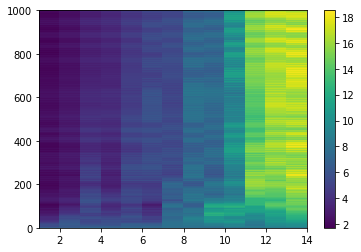

In [7]:
dist_plot = np.zeros((NUM_ROUNDS, NUM_CASTLES))
for i in range(NUM_ROUNDS):
    for j in range(NUM_CASTLES):
        for k in range(NUM_SOLDIERS):
            dist_plot[i,j] += dist[i,j,k]*k
dist_plot /= NUM_CONTENDERS
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, NUM_ROUNDS+1), dist_plot)
plt.colorbar()

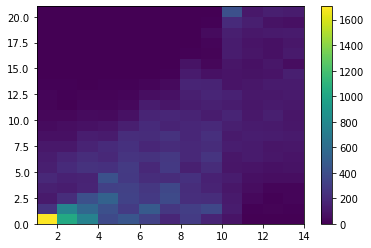

In [8]:
MAX_PLOT_SOLDIERS = 20
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, MAX_PLOT_SOLDIERS+2), dist[-1,:,:MAX_PLOT_SOLDIERS+1].T)
plt.colorbar()

In [9]:
for i in range(NUM_CONTENDERS):
    print(contenders[i])

[ 4  1  8  7  7 10  5 10 14  6  2 15 11]
[ 4  1  8  7  7 10  5 10 14  6  2 15 11]
[ 4  4  6  4  3  9 10  7 12 10  4 15 12]
[ 4  4  6  4  3  9 10  7 12 10  4 15 12]
[ 4  6  5  5  3  8 10  9 14 14  3 12  7]
[ 4  6  5  5  3  8 10  9 14 14  3 12  7]
[ 5  6  7  4  9  3  4  3  9 21  5 12 12]
[ 5  6  7  3  9  4  4  3  9 21  5 12 12]
[ 1  6  9  7  5 10  7  9  8 20  4  6  8]
[ 1  6  9  7  5 10  7  9  8 20  4  6  8]
[ 1  1  0  4  5  5 10  5 18 19  2 16 14]
[ 2  1  0  4  4  5 10  5 18 19  2 16 14]
[ 0  1  0  4  5  6 10  5 18 19  2 17 13]
[ 1  1  0  4  4  6 10  5 18 19  2 17 13]
[ 7  6  2  7  7 10  9  7  5 21  3  7  9]
[ 7  6  3  6 10  9  9  6  5 20  4  6  9]
[ 1  1  0  4  4  6 10  5 18 19  2 16 14]
[ 1  1  0  4  4  6 10  5 18 19  2 16 14]
[ 9  8  4  2 10  7  7  6  8 20  6  5  8]
[ 9  7  4  4  9  8  7  6  8 20  4  5  9]
[ 6  4  3  8  3  4 15 10  6 22  5  8  6]
[ 6  4  3  8  3  4 15 10  6 22  5  8  6]
[ 0  0  4  1  7  7  1  8  0  0 14 28 30]
[ 0  1  4  1  7  6  0 10  0  0 15 26 30]
[ 0  0  6  0  7 

[ 0  0  2  1  6  0  2  0  1 20 23 19 26]
[ 1  0  2  2  0  6  7  9  5 14 20 11 23]
[ 0  0  2  2  1  4  1  6  4 20 20 13 27]
[ 0  0  0  1  1  1 12  4 11  7 19 22 22]
[ 1  3  2  3  1  3  6  6  7 14 21  9 24]
[ 0  0  4  1  3  4  3  8  4 17 20 10 26]
[ 0  0  0  3  1  1  6  0  3 20 23 18 25]
[ 2  3  8  6  8  8  9  6 14 11  5 16  4]
[ 0  0  8  0  7  6  0 13  2  1 14 25 24]
[ 0  0  2  2  3  8  6 13  4  2 20 25 15]
[ 0  0  8  1  6  6  0 11  1  0 18 24 25]
[ 0  0  0  2  0  8  1  9  7  3 25 21 24]
[ 0  0  2  3  5  1  2  0  2 20 22 20 23]
[ 0  0  1  0  0  2 11  5  8  9 23 23 18]
[ 0  1  1  3  0  9  7 15  4  3 18 23 16]
[ 1  0  3  3  1  3  3  6  6 19 17 11 27]
[ 0  0  0  3  0  9  0  9  9  3 27 20 20]
[ 0  1  1  2  3  1  1  0  0 20 24 21 26]
[ 0  1  1  2  0 10  7 15  4  3 18 23 16]
[ 0  0  1  0  1  0  6  3  1 20 22 20 26]
[ 0  0  0  2  0  8  1  9  7  3 25 21 24]
[ 1  0  2  0  5  6  7 14  3  2 20 24 16]
[ 0  0  1  2  4  7  6 12  4  4 20 24 16]
[ 0  1  0  2  0  0  2  1  0 21 24 23 26]
[ 0  1  1  1  2 

In [16]:
NUM_CONTENDERS=1000
wins = battle_royale(winners_circle)
win_index = wins.argmax()
winner = winners_circle[win_index]
print(datetime.datetime.now(), winner, wins[win_index], win_index)
NUM_CONTENDERS=3000

2020-09-05 10:54:14.394229 [ 0  0  0  2  0  1  2  1  1 20 23 25 25] 871 998


In [15]:
for i in range(NUM_ROUNDS):
    print(winners_circle[i], wins[i])

[ 4  3  6 12  5  7  9  4 10  9 11 11  9] 0
[ 6  5 10  3  3 12 10  5 10 10 10  3 13] 1
[ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2
[ 6  5 10  3  3 12 10  5 10 10 10  3 13] 3
[ 6  5 10  3  3 12 10  5 10 10 10  3 13] 4
[ 6  5 10  3  3 12 10  5 10 10 10  3 13] 5
[ 6  5 10  3  3 12 10  5 10 10 10  3 13] 6
[ 6  5 10  3  3 12 10  5 10 10 10  3 13] 7
[ 6  5  5  4 12  6  6  3 10  9 11 12 11] 1
[ 6  5  5  4 12  6  6  3 10  9 11 12 11] 2
[ 6  5  5  4 12  6  6  3 10  9 11 12 11] 3
[ 6  5  5  4 12  6  6  3 10  9 11 12 11] 4
[ 3  7  5  5  6  7  3 11  6  9  8 14 16] 5
[ 3  7  5  5  6  7  3 11  6  9  8 14 16] 6
[ 3  7  5  5  6  7  3 11  6  9  8 14 16] 7
[ 3  7  5  5  6  7  3 11  6  9  8 14 16] 8
[ 3  7  5  5  6  7  3 11  6  9  8 14 16] 9
[ 3  7  5  5  6  7  3 11  6  9  8 14 16] 10
[ 3  7  5  5  6  7  3 11  6  9  8 14 16] 11
[ 3  7  5  5  6  7  3 11  6  9  8 14 16] 12
[ 3  7  5  5  6  7  3 11  6  9  8 14 16] 13
[ 3  7  5  5  6  7  3 11  6  9  8 14 16] 14
[ 3  7  5  5  6  7  3 11  6  9  8 14 16] 15
[ 3  

In [17]:
winners_circle2 = np.zeros((NUM_ROUNDS, NUM_CASTLES), dtype=np.int8)
dist2 = np.zeros((NUM_ROUNDS, NUM_CASTLES, NUM_SOLDIERS+1), dtype=np.int32)
for i in range(NUM_ROUNDS):
    for j in range(NUM_CONTENDERS):
        for k in range(NUM_CASTLES):
            dist2[i,k,contenders[j,k]] += 1
    wins = battle_royale(contenders)
    win_index = wins.argmax()
    winner = contenders[win_index]
    print(datetime.datetime.now(), winner, wins[win_index])
    winners_circle2[i] = winner
    evolve_contenders(contenders, wins)

2020-09-05 11:00:59.739509 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 1427
2020-09-05 11:01:38.852973 [ 0  1  1  5  6  2  8  0 11  6 22 21 17] 1459
2020-09-05 11:02:18.314458 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1503
2020-09-05 11:02:57.463789 [ 0  1  1  4  3  4  6  4  2 18 12 17 28] 1476
2020-09-05 11:03:36.799731 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 1518
2020-09-05 11:04:16.413165 [ 0  1  1  5  6  2  8  0 11  6 22 21 17] 1442
2020-09-05 11:04:56.588307 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1521
2020-09-05 11:05:35.696714 [ 0  1  2  0  0  1  3  1  1 19 25 21 26] 1474
2020-09-05 11:06:14.745183 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1522
2020-09-05 11:06:54.989741 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 1427
2020-09-05 11:07:34.908504 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1496
2020-09-05 11:08:14.431112 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1470
2020-09-05 11:08:55.097393 [ 0  1  1  4  3  4  6  4  2 18 12 17 28] 1477
2020-09-05 11:09:33.685282 [ 1  6  9  7  5 10  7  9

2020-09-05 12:14:44.927318 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1476
2020-09-05 12:15:23.812003 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 1456
2020-09-05 12:16:03.057311 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1495
2020-09-05 12:16:42.581860 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1510
2020-09-05 12:17:22.005109 [ 0  1  1  4  3  4  6  4  2 18 12 17 28] 1446
2020-09-05 12:18:00.396781 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 1492
2020-09-05 12:18:39.489196 [ 0  1  0  0  4  1  3 10 12  0 17 29 23] 1416
2020-09-05 12:19:18.884762 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1520
2020-09-05 12:19:58.094524 [ 0  0  1  2  2  1  3  0  0 17 25 21 28] 1483
2020-09-05 12:20:36.569884 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 1503
2020-09-05 12:21:15.046723 [ 0  1  0  0  4  1  3 10 12  0 17 29 23] 1407
2020-09-05 12:21:54.173686 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1518
2020-09-05 12:22:33.330270 [ 0  1  0  2  0  0  2  1  0 21 24 23 26] 1484
2020-09-05 12:23:12.107001 [ 0  1  4  1  7  6  0 10

2020-09-05 13:28:32.337974 [ 0  1  0  0  4  1  3 10 12  0 17 29 23] 1427
2020-09-05 13:29:11.238085 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1525
2020-09-05 13:29:51.003703 [ 0  0  1  2  2  1  3  0  0 17 25 21 28] 1466
2020-09-05 13:30:29.299254 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 1519
2020-09-05 13:31:08.350538 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1441
2020-09-05 13:31:47.579908 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1516
2020-09-05 13:32:26.778878 [ 0  0  1  2  2  1  3  0  0 17 25 21 28] 1467
2020-09-05 13:33:05.433303 [ 0  1  2  1  3  0  3  4  6 16 26 24 14] 1486
2020-09-05 13:33:44.106659 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1435
2020-09-05 13:34:23.557450 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1504
2020-09-05 13:35:03.024169 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1483
2020-09-05 13:35:42.422279 [ 0  1  2  1  3  0  3  4  6 16 26 24 14] 1453
2020-09-05 13:36:21.705748 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 1462
2020-09-05 13:37:01.127092 [ 4  1  8  7  7 10  5 10

2020-09-05 14:42:29.768329 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1481
2020-09-05 14:43:09.236816 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1489
2020-09-05 14:43:50.657580 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1545
2020-09-05 14:44:30.452621 [ 0  1  2  1  3  0  3  4  6 16 26 24 14] 1454
2020-09-05 14:45:09.486905 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1456
2020-09-05 14:45:49.596030 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1442
2020-09-05 14:46:30.189565 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1562
2020-09-05 14:47:09.814041 [ 0  0  1  2  2  1  3  0  0 17 25 21 28] 1463
2020-09-05 14:47:49.063275 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1468
2020-09-05 14:48:28.348544 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1450
2020-09-05 14:49:07.834184 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1562
2020-09-05 14:49:47.131172 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1473
2020-09-05 14:50:26.845668 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1487
2020-09-05 14:51:06.033793 [ 0  0  0  3  0  9  0  9

2020-09-05 15:56:24.150111 [ 0  1  2  0  3  0  3  3  6 16 25 27 14] 1507
2020-09-05 15:57:03.666766 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1478
2020-09-05 15:57:43.302925 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1513
2020-09-05 15:58:22.867380 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1553
2020-09-05 15:59:01.717666 [ 0  0  1  2  2  1  3  0  0 17 25 21 28] 1473
2020-09-05 15:59:40.217329 [ 0  1  2  1  3  0  3  4  6 16 26 24 14] 1486
2020-09-05 16:00:19.434933 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1466
2020-09-05 16:00:58.690321 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1573
2020-09-05 16:01:38.969337 [ 0  0  1  2  2  1  3  0  0 17 25 21 28] 1501
2020-09-05 16:02:17.623559 [ 0  1  2  1  3  0  3  4  6 16 26 24 14] 1497
2020-09-05 16:02:56.150663 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1497
2020-09-05 16:03:36.061605 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1582
2020-09-05 16:04:15.776050 [ 0  0  1  2  2  1  3  0  0 17 25 21 28] 1494
2020-09-05 16:04:54.698600 [ 0  1  2  1  3  0  3  4

2020-09-05 17:10:16.467390 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1455
2020-09-05 17:10:56.424244 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1541
2020-09-05 17:11:35.619502 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1519
2020-09-05 17:12:14.715355 [ 0  1  2  1  3  0  3  4  6 16 26 24 14] 1469
2020-09-05 17:12:53.135338 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1454
2020-09-05 17:13:32.811680 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1492
2020-09-05 17:14:12.682799 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1546
2020-09-05 17:14:51.739406 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1437
2020-09-05 17:15:30.477812 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1501
2020-09-05 17:16:09.417310 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1463
2020-09-05 17:16:49.074224 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1539
2020-09-05 17:17:29.293807 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1481
2020-09-05 17:18:09.017550 [ 0  1  2  0  3  0  3  3  6 16 25 27 14] 1504
2020-09-05 17:18:47.916229 [ 0  0  0  3  0  9  0  9

2020-09-05 18:24:04.403876 [ 0  1  2  1  3  0  3  4  6 16 26 24 14] 1475
2020-09-05 18:24:43.347177 [ 4  6  6  7  3  8 10  7  7 20 11  7  4] 1662
2020-09-05 18:25:22.693165 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1579
2020-09-05 18:26:02.042197 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1553
2020-09-05 18:26:41.938732 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1471
2020-09-05 18:27:20.855779 [ 4  6  6  7  3  8 10  7  7 20 11  7  4] 1607
2020-09-05 18:27:59.987249 [ 4  6  6  7  3  8 10  7  7 20 11  7  4] 1617
2020-09-05 18:28:39.342746 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1537
2020-09-05 18:29:18.971535 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1576
2020-09-05 18:29:58.033146 [ 0  1  2  1  3  0  3  4  6 16 26 24 14] 1501
2020-09-05 18:30:37.191337 [ 4  6  6  7  3  8 10  7  7 20 11  7  4] 1673
2020-09-05 18:31:16.433863 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1556
2020-09-05 18:31:55.686349 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1592
2020-09-05 18:32:34.905401 [ 4  1  8  7  7 10  5 10

2020-09-05 19:38:01.305151 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1632
2020-09-05 19:38:40.304177 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1474
2020-09-05 19:39:18.934082 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1582
2020-09-05 19:39:58.313332 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1561
2020-09-05 19:40:37.824060 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1657
2020-09-05 19:41:17.441527 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1548
2020-09-05 19:41:56.056435 [ 4  6  6  7  3  8 10  7  7 20 11  7  4] 1533
2020-09-05 19:42:35.278313 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1644
2020-09-05 19:43:14.551136 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1614
2020-09-05 19:43:54.055583 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1594
2020-09-05 19:44:33.232250 [ 0  1  2  1  3  0  3  4  6 16 26 24 14] 1478
2020-09-05 19:45:11.938605 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1621
2020-09-05 19:45:51.265545 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1547
2020-09-05 19:46:30.327709 [ 4  1  8  7  7 10  5 10

2020-09-05 20:51:57.386593 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1499
2020-09-05 20:52:37.198358 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1562
2020-09-05 20:53:16.563559 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1508
2020-09-05 20:53:55.752902 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1636
2020-09-05 20:54:35.552517 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1585
2020-09-05 20:55:15.002540 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1542
2020-09-05 20:55:54.697497 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1470
2020-09-05 20:56:33.501072 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1597
2020-09-05 20:57:12.742870 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1644
2020-09-05 20:57:52.765517 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1539
2020-09-05 20:58:33.230651 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1529
2020-09-05 20:59:12.594163 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1502
2020-09-05 20:59:51.267880 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1639
2020-09-05 21:00:31.185932 [ 0  0  0  3  0  9  0  9

In [19]:
new_winners_circle = np.zeros((3*NUM_ROUNDS, NUM_CASTLES), dtype=np.int8)
new_winners_circle[:NUM_ROUNDS,:] = winners_circle
new_winners_circle[NUM_ROUNDS:2*NUM_ROUNDS,:] = winners_circle2

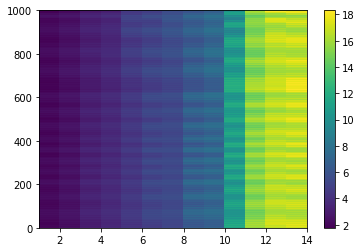

In [20]:
dist_plot = np.zeros((NUM_ROUNDS, NUM_CASTLES))
for i in range(NUM_ROUNDS):
    for j in range(NUM_CASTLES):
        for k in range(NUM_SOLDIERS):
            dist_plot[i,j] += dist2[i,j,k]*k
dist_plot /= NUM_CONTENDERS
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, NUM_ROUNDS+1), dist_plot)
plt.colorbar()

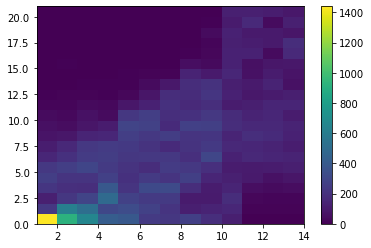

In [21]:
MAX_PLOT_SOLDIERS = 20
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, MAX_PLOT_SOLDIERS+2), dist2[-1,:,:MAX_PLOT_SOLDIERS+1].T)
plt.colorbar()

In [22]:
NUM_CONTENDERS=2000
wins = battle_royale(new_winners_circle[:2*NUM_ROUNDS,:])
win_index = wins.argmax()
winner = new_winners_circle[win_index]
print(datetime.datetime.now(), winner, wins[win_index], win_index)
NUM_CONTENDERS=3000

2020-09-06 09:56:08.751922 [ 1  1  0  4  4  6 10  5 18 19  2 17 13] 1307 1962


In [23]:
winners_circle3 = np.zeros((NUM_ROUNDS, NUM_CASTLES), dtype=np.int8)
dist3 = np.zeros((NUM_ROUNDS, NUM_CASTLES, NUM_SOLDIERS+1), dtype=np.int32)
for i in range(NUM_ROUNDS):
    for j in range(NUM_CONTENDERS):
        for k in range(NUM_CASTLES):
            dist3[i,k,contenders[j,k]] += 1
    wins = battle_royale(contenders)
    win_index = wins.argmax()
    winner = contenders[win_index]
    print(datetime.datetime.now(), winner, wins[win_index])
    winners_circle3[i] = winner
    evolve_contenders(contenders, wins)

2020-09-06 09:58:19.033485 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1497
2020-09-06 09:58:57.802501 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1556
2020-09-06 09:59:35.059535 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1500
2020-09-06 10:00:14.785327 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1531
2020-09-06 10:00:52.259492 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1465
2020-09-06 10:01:30.705880 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1558
2020-09-06 10:02:08.423585 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1504
2020-09-06 10:02:48.757859 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1514
2020-09-06 10:03:26.280473 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1449
2020-09-06 10:04:04.954287 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1567
2020-09-06 10:04:42.243582 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1535
2020-09-06 10:05:21.720882 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1515
2020-09-06 10:05:59.782893 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1472
2020-09-06 10:06:38.809493 [ 0  0  0  3  0  9  0  9

2020-09-06 11:10:41.824174 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1524
2020-09-06 11:11:20.070022 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1555
2020-09-06 11:12:00.256964 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1537
2020-09-06 11:12:38.540344 [ 1  1  1  3  6  4  9  0 12  2 16 26 19] 1452
2020-09-06 11:13:17.232272 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1480
2020-09-06 11:13:54.704013 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1501
2020-09-06 11:14:34.598589 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1566
2020-09-06 11:15:12.668354 [ 1  1  1  3  6  4  9  0 12  2 16 26 19] 1439
2020-09-06 11:15:51.625977 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1455
2020-09-06 11:16:28.948550 [ 2  4  5  4 10  7 10  9 15 12  9  8  5] 1483
2020-09-06 11:17:08.966902 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1574
2020-09-06 11:17:46.784042 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1452
2020-09-06 11:18:25.644393 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1490
2020-09-06 11:19:03.253224 [ 0  0  0  3  0  9  0  9

2020-09-06 12:23:07.198991 [ 6  3  8  5  9 11  6  7  8 22  3  8  4] 1477
2020-09-06 12:23:45.914160 [ 5  3  3  6 10  8  7 13 12 17  4  3  9] 1450
2020-09-06 12:24:23.633429 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1557
2020-09-06 12:25:03.798275 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1544
2020-09-06 12:25:41.387303 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1461
2020-09-06 12:26:20.853821 [ 0  0  1  2  4  7  6 12  4  4 20 24 16] 1440
2020-09-06 12:26:58.733557 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1505
2020-09-06 12:27:38.315443 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1586
2020-09-06 12:28:16.269309 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1499
2020-09-06 12:28:54.970970 [ 6  3  8  5  9 11  6  7  8 22  3  8  4] 1455
2020-09-06 12:29:32.823949 [ 5  3  3  6 10  8  7 13 12 17  4  3  9] 1439
2020-09-06 12:30:12.360237 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1598
2020-09-06 12:30:50.351846 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1581
2020-09-06 12:31:29.131582 [ 0  0  1  2  4  7  6 12

2020-09-06 13:35:52.015633 [ 0  0  2  2  3  8  6 13  4  2 20 25 15] 1408
2020-09-06 13:36:30.410541 [ 5  1  4  5  5 13 11 11 14  6  7 10  8] 1539
2020-09-06 13:37:09.709609 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1718
2020-09-06 13:37:47.450175 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1593
2020-09-06 13:38:26.420559 [ 0  1  2  2  2  3  3  1  5 12 25 15 29] 1431
2020-09-06 13:39:04.006972 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1396
2020-09-06 13:39:43.070723 [ 5  1  4  5  5 13 11 11 14  6  7 10  8] 1695
2020-09-06 13:40:21.296904 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1688
2020-09-06 13:41:00.719200 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1511
2020-09-06 13:41:38.365413 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1377
2020-09-06 13:42:17.455083 [ 5  1  4  5  5 13 11 11 14  6  7 10  8] 1526
2020-09-06 13:42:55.613066 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1698
2020-09-06 13:43:35.222237 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1578
2020-09-06 13:44:13.086629 [ 0  1  2  2  2  3  3  1

2020-09-06 14:48:39.016496 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1446
2020-09-06 14:49:18.414522 [ 5  1  4  5  5 13 11 11 14  6  7 10  8] 1691
2020-09-06 14:49:56.650904 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1685
2020-09-06 14:50:36.204240 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1520
2020-09-06 14:51:13.534589 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1447
2020-09-06 14:51:52.612486 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1587
2020-09-06 14:52:30.832501 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1699
2020-09-06 14:53:10.275637 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1599
2020-09-06 14:53:47.831771 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1433
2020-09-06 14:54:26.586423 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1450
2020-09-06 14:55:04.537071 [ 5  1  4  5  5 13 11 11 14  6  7 10  8] 1700
2020-09-06 14:55:43.606511 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1688
2020-09-06 14:56:21.187627 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1508
2020-09-06 14:57:00.177240 [ 0  0  0  2  1  8  0  9

2020-09-06 16:01:24.643123 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1658
2020-09-06 16:02:03.139412 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1648
2020-09-06 16:02:42.914900 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1461
2020-09-06 16:03:20.877595 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1476
2020-09-06 16:03:59.475087 [ 5  1  4  5  5 13 11 11 14  6  7 10  8] 1637
2020-09-06 16:04:37.660979 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1663
2020-09-06 16:05:17.049556 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1536
2020-09-06 16:05:54.591620 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1477
2020-09-06 16:06:33.756423 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1624
2020-09-06 16:07:12.306140 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1682
2020-09-06 16:07:52.212522 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1596
2020-09-06 16:08:30.185954 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1431
2020-09-06 16:09:08.929948 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1477
2020-09-06 16:09:46.683141 [ 5  1  4  5  5 13 11 11

2020-09-06 17:14:17.765315 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1446
2020-09-06 17:14:56.669359 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1550
2020-09-06 17:15:34.501718 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1655
2020-09-06 17:16:14.458744 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1669
2020-09-06 17:16:52.452661 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1544
2020-09-06 17:17:31.341111 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1479
2020-09-06 17:18:08.672081 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1505
2020-09-06 17:18:47.823661 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1654
2020-09-06 17:19:26.031451 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1595
2020-09-06 17:20:05.623328 [ 0  1  2  2  2  3  3  1  5 12 25 15 29] 1420
2020-09-06 17:20:43.484451 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1535
2020-09-06 17:21:22.826071 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1632
2020-09-06 17:22:01.336292 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1610
2020-09-06 17:22:40.763893 [ 4  1  8  7  7 10  5 10

2020-09-06 18:27:00.712227 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1594
2020-09-06 18:27:38.556448 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1442
2020-09-06 18:28:17.788274 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1499
2020-09-06 18:28:55.946867 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1671
2020-09-06 18:29:35.333156 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1623
2020-09-06 18:30:13.817907 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1483
2020-09-06 18:30:52.767658 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1515
2020-09-06 18:31:30.411289 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1614
2020-09-06 18:32:09.978973 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1655
2020-09-06 18:32:48.079075 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1551
2020-09-06 18:33:26.601861 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1479
2020-09-06 18:34:03.961838 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1532
2020-09-06 18:34:43.425589 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1623
2020-09-06 18:35:21.322846 [ 4  1  8  7  7 10  5 10

2020-09-06 19:39:53.490055 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1691
2020-09-06 19:40:33.447176 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1566
2020-09-06 19:41:11.533847 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1449
2020-09-06 19:41:50.476848 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1456
2020-09-06 19:42:28.547392 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1576
2020-09-06 19:43:08.038879 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1635
2020-09-06 19:43:45.960573 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1458
2020-09-06 19:44:24.632566 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1522
2020-09-06 19:45:02.245878 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1595
2020-09-06 19:45:41.740390 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1639
2020-09-06 19:46:20.738100 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1544
2020-09-06 19:46:59.906675 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1463
2020-09-06 19:47:37.360818 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1479
2020-09-06 19:48:16.781376 [ 0  1  6  6  0  2  1  9

In [24]:
new_winners_circle[2*NUM_ROUNDS:3*NUM_ROUNDS,:] = winners_circle3

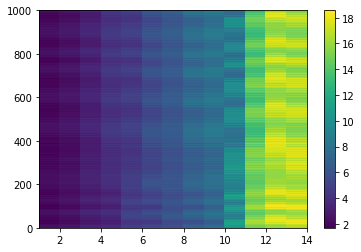

In [26]:
dist_plot = np.zeros((NUM_ROUNDS, NUM_CASTLES))
for i in range(NUM_ROUNDS):
    for j in range(NUM_CASTLES):
        for k in range(NUM_SOLDIERS):
            dist_plot[i,j] += dist3[i,j,k]*k
dist_plot /= NUM_CONTENDERS
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, NUM_ROUNDS+1), dist_plot)
plt.colorbar()

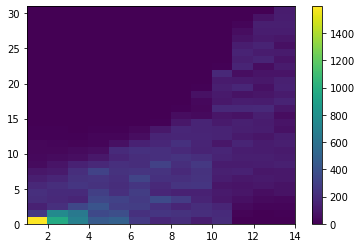

In [33]:
MAX_PLOT_SOLDIERS = 30
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, MAX_PLOT_SOLDIERS+2), dist3[-1,:,:MAX_PLOT_SOLDIERS+1].T)
plt.colorbar()

In [28]:
wins = battle_royale(new_winners_circle)
win_index = wins.argmax()
winner = new_winners_circle[win_index]
print(datetime.datetime.now(), winner, wins[win_index], win_index)

2020-09-06 22:26:51.497991 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 2152 2987


In [29]:
winners_circle4 = np.zeros((NUM_ROUNDS, NUM_CASTLES), dtype=np.int8)
dist4 = np.zeros((NUM_ROUNDS, NUM_CASTLES, NUM_SOLDIERS+1), dtype=np.int32)
for i in range(NUM_ROUNDS):
    for j in range(NUM_CONTENDERS):
        for k in range(NUM_CASTLES):
            dist4[i,k,contenders[j,k]] += 1
    wins = battle_royale(contenders)
    win_index = wins.argmax()
    winner = contenders[win_index]
    print(datetime.datetime.now(), winner, wins[win_index])
    winners_circle4[i] = winner
    evolve_contenders(contenders, wins)

2020-09-06 22:29:38.399465 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1487
2020-09-06 22:30:16.276747 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1684
2020-09-06 22:30:54.406359 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1564
2020-09-06 22:31:32.450179 [ 0  0  2  3  2  1  2  3  2 17 26 16 26] 1454
2020-09-06 22:32:09.751692 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1527
2020-09-06 22:32:47.372029 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1639
2020-09-06 22:33:25.075668 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1614
2020-09-06 22:34:02.713418 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1499
2020-09-06 22:34:40.087072 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1496
2020-09-06 22:35:17.768616 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1497
2020-09-06 22:35:55.258033 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1699
2020-09-06 22:36:33.509041 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1566
2020-09-06 22:37:10.974286 [ 0  0  1  2  2  5  3  2  1 13 26 18 27] 1463
2020-09-06 22:37:48.666058 [ 0  0  0  2  1  8  0  9

2020-09-06 23:40:51.289514 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1534
2020-09-06 23:41:29.407189 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1427
2020-09-06 23:42:06.794530 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1481
2020-09-06 23:42:44.853828 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1677
2020-09-06 23:43:23.128426 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1570
2020-09-06 23:44:00.749513 [ 0  0  2  3  2  1  2  3  2 17 26 16 26] 1465
2020-09-06 23:44:38.624810 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1516
2020-09-06 23:45:16.511934 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1643
2020-09-06 23:45:54.589994 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1624
2020-09-06 23:46:32.271230 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1512
2020-09-06 23:47:09.750366 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1477
2020-09-06 23:47:46.926070 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1482
2020-09-06 23:48:24.604007 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1647
2020-09-06 23:49:02.692387 [ 4  1  8  7  7 10  5 10

2020-09-07 00:52:12.792138 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1493
2020-09-07 00:52:50.687348 [ 0  1  1  0  0  3  2  2  1 21 19 20 30] 1423
2020-09-07 00:53:27.983363 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1490
2020-09-07 00:54:05.463666 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1638
2020-09-07 00:54:43.559312 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1621
2020-09-07 00:55:21.879245 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1475
2020-09-07 00:55:59.333658 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1497
2020-09-07 00:56:36.738114 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1518
2020-09-07 00:57:14.582745 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1601
2020-09-07 00:57:52.918619 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1514
2020-09-07 00:58:30.501665 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1461
2020-09-07 00:59:07.873968 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1516
2020-09-07 00:59:45.587267 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1678
2020-09-07 01:00:23.885737 [ 0  1  6  6  0  2  1  9

2020-09-07 02:03:14.858910 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1629
2020-09-07 02:03:52.723664 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1552
2020-09-07 02:04:30.670584 [ 0  1  2  2  2  3  3  1  5 12 25 15 29] 1473
2020-09-07 02:05:07.750171 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1492
2020-09-07 02:05:45.444599 [ 5  1  4  5  5 13 11 11 14  6  7 10  8] 1575
2020-09-07 02:06:23.326806 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1634
2020-09-07 02:07:01.212596 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1495
2020-09-07 02:07:38.359318 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1454
2020-09-07 02:08:15.791636 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1446
2020-09-07 02:08:53.674166 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1630
2020-09-07 02:09:32.094445 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1547
2020-09-07 02:10:09.596584 [ 0  1  2  2  2  3  3  1  5 12 25 15 29] 1436
2020-09-07 02:10:46.641899 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1495
2020-09-07 02:11:24.447470 [ 5  1  4  5  5 13 11 11

2020-09-07 03:14:18.835611 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1507
2020-09-07 03:14:57.298503 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1587
2020-09-07 03:15:35.557214 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1572
2020-09-07 03:16:13.818009 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1502
2020-09-07 03:16:51.069171 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1493
2020-09-07 03:17:28.859880 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1550
2020-09-07 03:18:06.783419 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1580
2020-09-07 03:18:44.846852 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1510
2020-09-07 03:19:22.220831 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1481
2020-09-07 03:19:59.706708 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1469
2020-09-07 03:20:37.679749 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1591
2020-09-07 03:21:15.713767 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1528
2020-09-07 03:21:53.049474 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1442
2020-09-07 03:22:30.175501 [ 0  0  0  2  1  8  0  9

2020-09-07 04:25:32.568457 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1486
2020-09-07 04:26:10.751443 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1591
2020-09-07 04:26:48.604582 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1518
2020-09-07 04:27:26.343128 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1470
2020-09-07 04:28:03.868128 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1492
2020-09-07 04:28:41.642093 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1633
2020-09-07 04:29:19.879916 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1557
2020-09-07 04:29:57.697925 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1483
2020-09-07 04:30:35.396400 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1503
2020-09-07 04:31:12.717693 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1565
2020-09-07 04:31:50.630855 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1579
2020-09-07 04:32:28.148746 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1498
2020-09-07 04:33:05.886030 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1497
2020-09-07 04:33:43.129015 [ 4  3  4  7  8 10 13 14

2020-09-07 05:36:34.361857 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1597
2020-09-07 05:37:12.736901 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1510
2020-09-07 05:37:49.869176 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1512
2020-09-07 05:38:27.505079 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1508
2020-09-07 05:39:05.383277 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1590
2020-09-07 05:39:44.436301 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1514
2020-09-07 05:40:22.371725 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1470
2020-09-07 05:40:59.882921 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1497
2020-09-07 05:41:37.855645 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1580
2020-09-07 05:42:16.209909 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1538
2020-09-07 05:42:53.839746 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1434
2020-09-07 05:43:31.031298 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1502
2020-09-07 05:44:08.648719 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1637
2020-09-07 05:44:46.962984 [ 4  1  8  7  7 10  5 10

2020-09-07 06:47:44.320514 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1529
2020-09-07 06:48:21.788820 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1507
2020-09-07 06:48:59.775515 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1586
2020-09-07 06:49:38.104833 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1505
2020-09-07 06:50:15.540120 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1494
2020-09-07 06:50:52.912842 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1470
2020-09-07 06:51:31.291213 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1584
2020-09-07 06:52:09.093088 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1528
2020-09-07 06:52:46.554095 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1441
2020-09-07 06:53:23.766315 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1507
2020-09-07 06:54:01.482396 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1598
2020-09-07 06:54:39.330307 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1575
2020-09-07 06:55:17.526297 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1471
2020-09-07 06:55:54.776793 [ 3  6  3  8  8  6 11 13

2020-09-07 07:58:55.331018 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1580
2020-09-07 07:59:32.857974 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1458
2020-09-07 08:00:10.195669 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1532
2020-09-07 08:00:48.113945 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1579
2020-09-07 08:01:26.159316 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1573
2020-09-07 08:02:04.575690 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1504
2020-09-07 08:02:42.603286 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1537
2020-09-07 08:03:20.478533 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1533
2020-09-07 08:03:58.635874 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1594
2020-09-07 08:04:36.853001 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1513
2020-09-07 08:05:14.335365 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1495
2020-09-07 08:05:51.729308 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1486
2020-09-07 08:06:29.763960 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1581
2020-09-07 08:07:08.067339 [ 4  1  8  7  7 10  5 10

In [30]:
final_winners_circle = np.zeros((5*NUM_ROUNDS, NUM_CASTLES), dtype=np.int8)
final_winners_circle[:3*NUM_ROUNDS,:] = new_winners_circle
final_winners_circle[3*NUM_ROUNDS:4*NUM_ROUNDS,:] = winners_circle4

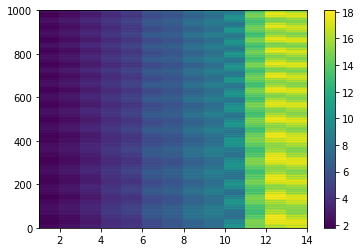

In [31]:
dist_plot = np.zeros((NUM_ROUNDS, NUM_CASTLES))
for i in range(NUM_ROUNDS):
    for j in range(NUM_CASTLES):
        for k in range(NUM_SOLDIERS):
            dist_plot[i,j] += dist4[i,j,k]*k
dist_plot /= NUM_CONTENDERS
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, NUM_ROUNDS+1), dist_plot)
plt.colorbar()

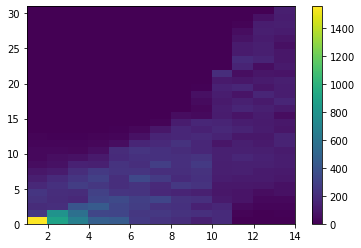

In [32]:
MAX_PLOT_SOLDIERS = 30
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, MAX_PLOT_SOLDIERS+2), dist4[-1,:,:MAX_PLOT_SOLDIERS+1].T)
plt.colorbar()

In [35]:
NUM_CONTENDERS=4000
wins = battle_royale(final_winners_circle)
win_index = wins.argmax()
winner = final_winners_circle[win_index]
print(datetime.datetime.now(), winner, wins[win_index], win_index)
NUM_CONTENDERS=3000

2020-09-07 09:23:56.557204 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 2873 3997


In [36]:
winners_circle5 = np.zeros((NUM_ROUNDS, NUM_CASTLES), dtype=np.int8)
dist5 = np.zeros((NUM_ROUNDS, NUM_CASTLES, NUM_SOLDIERS+1), dtype=np.int32)
for i in range(NUM_ROUNDS):
    for j in range(NUM_CONTENDERS):
        for k in range(NUM_CASTLES):
            dist5[i,k,contenders[j,k]] += 1
    wins = battle_royale(contenders)
    win_index = wins.argmax()
    winner = contenders[win_index]
    print(datetime.datetime.now(), winner, wins[win_index])
    winners_circle5[i] = winner
    evolve_contenders(contenders, wins)

2020-09-07 09:29:02.511991 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1491
2020-09-07 09:29:40.639725 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1586
2020-09-07 09:30:19.200579 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1549
2020-09-07 09:30:56.763826 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1425
2020-09-07 09:31:34.095673 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1529
2020-09-07 09:32:12.654416 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1575
2020-09-07 09:32:51.250804 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1567
2020-09-07 09:33:29.030270 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1457
2020-09-07 09:34:06.521149 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1526
2020-09-07 09:34:44.463239 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1564
2020-09-07 09:35:22.146083 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1585
2020-09-07 09:36:00.389663 [ 0  1  1  0  0  3  2  2  1 21 19 20 30] 1492
2020-09-07 09:36:38.240271 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1535
2020-09-07 09:37:16.333874 [ 4  3  4  7  8 10 13 14

2020-09-07 10:40:28.225543 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1441
2020-09-07 10:41:05.677430 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1501
2020-09-07 10:41:43.811216 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1576
2020-09-07 10:42:22.311284 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1576
2020-09-07 10:43:00.148940 [ 0  1  1  0  0  3  2  2  1 21 19 20 30] 1471
2020-09-07 10:43:37.582719 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1525
2020-09-07 10:44:15.241818 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1570
2020-09-07 10:44:54.367778 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1609
2020-09-07 10:45:32.654871 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1509
2020-09-07 10:46:09.334997 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1533
2020-09-07 10:46:46.813333 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1518
2020-09-07 10:47:25.154924 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1622
2020-09-07 10:48:03.391493 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1519
2020-09-07 10:48:40.697760 [ 3  6  3  8  8  6 11 13

2020-09-07 11:51:55.841232 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1592
2020-09-07 11:52:33.856504 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1482
2020-09-07 11:53:10.500827 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1527
2020-09-07 11:53:48.575447 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1555
2020-09-07 11:54:27.454326 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1599
2020-09-07 11:55:05.239702 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1513
2020-09-07 11:55:42.649988 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1526
2020-09-07 11:56:20.600676 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1502
2020-09-07 11:56:58.734176 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1623
2020-09-07 11:57:37.574389 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1521
2020-09-07 11:58:15.588521 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1470
2020-09-07 11:58:53.254532 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1485
2020-09-07 11:59:31.197803 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1597
2020-09-07 12:00:10.008648 [ 4  1  8  7  7 10  5 10

2020-09-07 13:03:34.730913 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1563
2020-09-07 13:04:12.352771 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1593
2020-09-07 13:04:50.122721 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1487
2020-09-07 13:05:27.615123 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1550
2020-09-07 13:06:06.074185 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1536
2020-09-07 13:06:44.773987 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1606
2020-09-07 13:07:23.790642 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1514
2020-09-07 13:08:00.627999 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1530
2020-09-07 13:08:37.811150 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1516
2020-09-07 13:09:16.511811 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1607
2020-09-07 13:09:55.025416 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1536
2020-09-07 13:10:32.295256 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1476
2020-09-07 13:11:09.424360 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1484
2020-09-07 13:11:47.405960 [ 4  1  8  7  7 10  5 10

2020-09-07 14:15:09.390104 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1481
2020-09-07 14:15:47.861125 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1572
2020-09-07 14:16:26.226085 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1526
2020-09-07 14:17:03.995109 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1474
2020-09-07 14:17:41.759346 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1479
2020-09-07 14:18:19.469749 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1574
2020-09-07 14:18:57.222169 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1582
2020-09-07 14:19:35.268322 [ 0  1  1  0  0  3  2  2  1 21 19 20 30] 1453
2020-09-07 14:20:12.883048 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1526
2020-09-07 14:20:51.006569 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1575
2020-09-07 14:21:29.727953 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1616
2020-09-07 14:22:07.307399 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1512
2020-09-07 14:22:44.683331 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1558
2020-09-07 14:23:22.387731 [ 4  3  4  7  8 10 13 14

2020-09-07 15:26:24.508715 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1511
2020-09-07 15:27:01.957429 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1492
2020-09-07 15:27:40.512784 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1624
2020-09-07 15:28:17.961209 [ 0  1  1  0  0  3  2  2  1 21 19 20 30] 1530
2020-09-07 15:28:55.117106 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1510
2020-09-07 15:29:32.439413 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1467
2020-09-07 15:30:10.684676 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1610
2020-09-07 15:30:48.813153 [ 0  1  1  0  0  3  2  2  1 21 19 20 30] 1531
2020-09-07 15:31:26.619298 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1482
2020-09-07 15:32:04.039675 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1502
2020-09-07 15:32:41.784903 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1605
2020-09-07 15:33:19.790917 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1561
2020-09-07 15:33:57.608228 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1437
2020-09-07 15:34:34.436793 [ 0  0  0  2  1  8  0  9

2020-09-07 16:37:37.445420 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1473
2020-09-07 16:38:14.890234 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1512
2020-09-07 16:38:51.992751 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1574
2020-09-07 16:39:30.926490 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1581
2020-09-07 16:40:09.252628 [ 0  1  1  0  0  3  2  2  1 21 19 20 30] 1481
2020-09-07 16:40:47.057672 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1524
2020-09-07 16:41:24.310974 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1572
2020-09-07 16:42:02.074878 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1595
2020-09-07 16:42:40.163588 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1516
2020-09-07 16:43:17.818591 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1530
2020-09-07 16:43:54.774362 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1530
2020-09-07 16:44:33.304380 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1603
2020-09-07 16:45:11.335314 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1533
2020-09-07 16:45:49.127029 [ 3  6  3  8  8  6 11 13

2020-09-07 17:49:13.794410 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1538
2020-09-07 17:49:50.781508 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1471
2020-09-07 17:50:28.837240 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1497
2020-09-07 17:51:06.305728 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1589
2020-09-07 17:51:44.812949 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1579
2020-09-07 17:52:22.212988 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1457
2020-09-07 17:53:00.312371 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1525
2020-09-07 17:53:37.564359 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1553
2020-09-07 17:54:16.420108 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1597
2020-09-07 17:54:54.000089 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1513
2020-09-07 17:55:31.735356 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1549
2020-09-07 17:56:09.567201 [ 5  1  4  5  5 13 11 11 14  6  7 10  8] 1506
2020-09-07 17:56:47.408845 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1623
2020-09-07 17:57:25.452977 [ 0  1  1  0  0  3  2  2

2020-09-07 19:00:39.943307 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1621
2020-09-07 19:01:18.251621 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1534
2020-09-07 19:01:55.764613 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1523
2020-09-07 19:02:33.797883 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 1506
2020-09-07 19:03:11.600776 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1608
2020-09-07 19:03:49.909015 [ 0  1  1  0  0  3  2  2  1 21 19 20 30] 1543
2020-09-07 19:04:27.052035 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 1490
2020-09-07 19:05:04.783217 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1489
2020-09-07 19:05:42.502233 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1603
2020-09-07 19:06:21.076124 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1539
2020-09-07 19:06:58.946579 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1481
2020-09-07 19:07:36.119083 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1504
2020-09-07 19:08:13.722123 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1576
2020-09-07 19:08:52.323417 [ 4  1  8  7  7 10  5 10

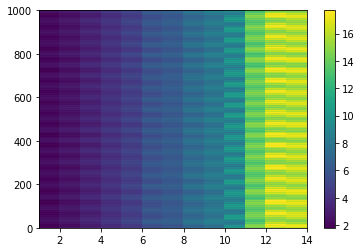

In [37]:
dist_plot = np.zeros((NUM_ROUNDS, NUM_CASTLES))
for i in range(NUM_ROUNDS):
    for j in range(NUM_CASTLES):
        for k in range(NUM_SOLDIERS):
            dist_plot[i,j] += dist5[i,j,k]*k
dist_plot /= NUM_CONTENDERS
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, NUM_ROUNDS+1), dist_plot)
plt.colorbar()

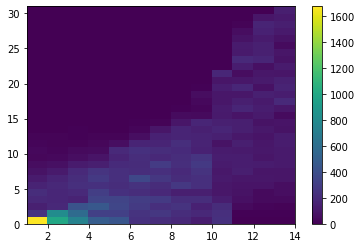

In [38]:
MAX_PLOT_SOLDIERS = 30
plt.pcolor(np.arange(1, NUM_CASTLES+2), np.arange(0, MAX_PLOT_SOLDIERS+2), dist5[-1,:,:MAX_PLOT_SOLDIERS+1].T)
plt.colorbar()

In [40]:
final_winners_circle[4*NUM_ROUNDS:5*NUM_ROUNDS,:] = winners_circle5
NUM_CONTENDERS=5000
wins = battle_royale(final_winners_circle)
win_index = wins.argmax()
winner = final_winners_circle[win_index]
print(datetime.datetime.now(), winner, wins[win_index], win_index)
NUM_CONTENDERS=3000

2020-09-07 20:56:20.932598 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 3591 4997


In [41]:
for i in range(5000):
    print(i, final_winners_circle[i], wins[i])

0 [ 4  3  6 12  5  7  9  4 10  9 11 11  9] 0
1 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 1
2 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 2
3 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 3
4 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 4
5 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 5
6 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 6
7 [ 6  5 10  3  3 12 10  5 10 10 10  3 13] 7
8 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 1
9 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 2
10 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 3
11 [ 6  5  5  4 12  6  6  3 10  9 11 12 11] 4
12 [ 3  7  5  5  6  7  3 11  6  9  8 14 16] 5
13 [ 3  7  5  5  6  7  3 11  6  9  8 14 16] 6
14 [ 3  7  5  5  6  7  3 11  6  9  8 14 16] 7
15 [ 3  7  5  5  6  7  3 11  6  9  8 14 16] 8
16 [ 3  7  5  5  6  7  3 11  6  9  8 14 16] 9
17 [ 3  7  5  5  6  7  3 11  6  9  8 14 16] 10
18 [ 3  7  5  5  6  7  3 11  6  9  8 14 16] 11
19 [ 3  7  5  5  6  7  3 11  6  9  8 14 16] 12
20 [ 3  7  5  5  6  7  3 11  6  9  8 14 16] 13
21 [ 3  7  5  5  6  7  3 11  6  9  8 14 

1052 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 597
1053 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 486
1054 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 411
1055 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 412
1056 [ 0  1  2  0  3  0  3  3  6 16 25 27 14] 562
1057 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 488
1058 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 414
1059 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 415
1060 [ 0  0  1  2  2  1  3  0  0 17 25 21 28] 624
1061 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 490
1062 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 491
1063 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 418
1064 [ 0  1  0  2  0  0  2  1  0 21 24 23 26] 886
1065 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 604
1066 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 492
1067 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 421
1068 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 422
1069 [ 0  1  2  0  3  0  3  3  6 16 25 27 14] 571
1070 [ 1  6  9  7  5 10  7  9  8 20  4  6  8] 494
1071 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 424


2208 [ 6  3  8  5  9 11  6  7  8 22  3  8  4] 747
2209 [ 5  3  3  6 10  8  7 13 12 17  4  3  9] 893
2210 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1340
2211 [ 0  0  2  3  2  2  2  3  2 17 26 15 26] 652
2212 [ 0  1  2  2  2  3  3  1  5 12 25 15 29] 659
2213 [ 0  1  1  3  1  9  5 12  8  2 19 21 18] 1566
2214 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1343
2215 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1344
2216 [ 0  1  2  2  2  3  3  1  5 12 25 15 29] 660
2217 [ 6  3  8  5  9 11  6  7  8 22  3  8  4] 751
2218 [ 5  3  3  6 10  8  7 13 12 17  4  3  9] 899
2219 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1348
2220 [ 1  0  1  2  0  5  3  3  2 13 25 18 27] 1077
2221 [ 6  3  8  5  9 11  6  7  8 22  3  8  4] 753
2222 [ 0  1  1  3  1  9  5 12  8  2 19 21 18] 1574
2223 [ 1  3  5  6  8 12  9  6 12 10  6 10 12] 1418
2224 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 1350
2225 [ 1  0  1  2  0  5  3  3  2 13 25 18 27] 1080
2226 [ 6  3  8  5  9 11  6  7  8 22  3  8  4] 755
2227 [ 5  3  3  6 10  8  7 13 12 17  4  

3385 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1273
3386 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1421
3387 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 2391
3388 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1403
3389 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1277
3390 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1779
3391 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 2393
3392 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1406
3393 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 2360
3394 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1781
3395 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1424
3396 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1408
3397 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 2364
3398 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1282
3399 [ 0  1  4  1  7  6  0 10  0  0 15 26 30] 1785
3400 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 2399
3401 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1411
3402 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 2368
3403 [ 0  1  2  2  2  3  3  1  5 12 25 15 29] 1281
3404 [ 0  0  0  2  1  8  0  9  

4552 [ 0  0  0  3  0  9  0  9  9  3 27 20 20] 1504
4553 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1839
4554 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 3287
4555 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 3288
4556 [ 0  1  1  0  0  3  2  2  1 21 19 20 30] 3062
4557 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1841
4558 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1820
4559 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 3291
4560 [ 0  1  1  0  0  3  2  2  1 21 19 20 30] 3065
4561 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 3103
4562 [ 0  1  6  6  0  2  1  9 18 10 18  7 22] 1822
4563 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 3293
4564 [ 0  1  1  3  3  1  3  3  2 16 26 15 26] 1967
4565 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 3106
4566 [ 4  3  4  7  8 10 13 14  7 10 10  6  4] 3215
4567 [ 4  1  8  7  7 10  5 10 14  6  2 15 11] 3295
4568 [ 0  1  1  0  0  3  2  2  1 21 19 20 30] 3070
4569 [ 3  6  3  8  8  6 11 13  9 21  3  3  6] 3109
4570 [ 0  0  0  2  1  8  0  9  7  4 25 21 23] 1846
4571 [ 4  1  8  7  7 10  5 10 1

In [43]:
# Fix this function.
def battle_royale(contenders):
    wins = np.zeros((NUM_CONTENDERS,), dtype=np.int32)
    for i in range(NUM_CONTENDERS):
        for j in range(i+1, NUM_CONTENDERS):
            outcome = battle_cmp(contenders[i], contenders[j])
            if outcome > 0:
                wins[i] += 1
            elif outcome < 0:
                wins[j] += 1
    return wins

In [44]:
NUM_CONTENDERS=5000
wins = battle_royale(final_winners_circle)
win_index = wins.argmax()
winner = final_winners_circle[win_index]
print(datetime.datetime.now(), winner, wins[win_index], win_index)
NUM_CONTENDERS=3000

2020-09-07 21:08:04.533962 [ 0  1  0  2  0  0  2  1  0 21 24 23 26] 3883 1029
